<a href="https://colab.research.google.com/github/mtjon/infompr-group-project/blob/feature%2Frnn/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title Generation through Abstract Summarisation with RNNs



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text==2.9.* tensorflow==2.9.*
!pip install einops

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 21 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 12s (37.2 MB/s)
(Reading database ... 129504 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 to 8.1.0.77-1+cuda11.2
(Reading database ... 129481 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.

In [34]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text
import tensorflow_text as tf_text

## Data import

In [125]:
import einops

#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [35]:
import random
from random import shuffle
# Seed voor herhaalbaarheid
random.seed(42)

In [102]:
# modified data externally to remove all blank lines
def write_data(f, ext, mod):
    # Code van https://github.com/EagleW/Writing-editing-Network/blob/master/split_data.py
    file1=open(f, 'r')
    lines=file1.readlines()
    print(len(lines))
    file1.close()
    abs_t = []
    abstracts = []
    titles = []
    i = 0
    # TODO: possibly generates wrong tibs/abs when encounter
    for line in lines:
        if i % mod == 0:
            titles.append(line)
        elif i % mod == 1:
            abstracts.append(line)
        i += 1
    for i in range(len(abstracts)):
        if len(titles[i]) > 0 and len(abstracts[i]) > 0:
            h_a_pair = (titles[i], abstracts[i])
            abs_t.append(h_a_pair)
    shuffle(abs_t)
    total = len(abs_t)
    dev = total//10
    train  = total - dev - dev
    i = 0
    file1=open("val{}.txt".format(ext), 'w')
    for i in range(dev):
        file1.writelines(abs_t[i][0])
        file1.writelines(abs_t[i][1])
    #    file1.writelines("\n")
    file1.close()
    file1=open("test{}.txt".format(ext), 'w')
    for i in range(dev, 2 * dev):
        file1.writelines(abs_t[i][0])
        file1.writelines(abs_t[i][1])
    #    file1.writelines("\n")
    file1.close()
    file1=open("train{}.txt".format(ext), 'w')
    for i in range(2 * dev, total):
        file1.writelines(abs_t[i][0])
        file1.writelines(abs_t[i][1])
    #    file1.writelines("\n")
    file1.close()

In [103]:
def get_abs_and_titles_from_raw(path_to_file):
    abstracts, titles = [], []
    abscount, titcount = 0, 0
    with open(path_to_file) as data:
        lines = data.readlines()
        print(len(lines))
        for abs in lines[1::2]:
            abstracts.append(abs.strip())
            abscount += 1
        for title in lines[0::2]:
            # // TODO: check if we need to add start and end tokens
            titles.append(title.strip())
            titcount+=1
            # titles.append('[START] ' + title.strip() + ' [END]')
    print(abscount, titcount)
    print(titles[-1],'\n',titles[-2])
    return abstracts, titles

In [104]:
# Necessary when upload fails (Firefox+Colab issue)

# from google.colab import files
# uploaded = files.upload()

In [105]:
write_data("acl_titles_and_abstracts_mod.txt", "", 2) # writes train, val, test.txt


21750


In [106]:
train_text, train_labels = get_abs_and_titles_from_raw('train.txt')
val_text, val_labels = get_abs_and_titles_from_raw('val.txt')

17402
8701 8701
combining multiple models for speech information retrieval 
 three-dimensional parametrization for parsing morphologically rich languages
2174
1087 1087
putting it simply : a context-aware approach to lexical simplification communication & information 
 bio-medical entity extraction using support vector machines


In [107]:
print(train_labels[0])
print(train_text[0])

toward completeness in concept extraction and classification
many algorithms extract terms from text together with some kind of taxonomic classification ( is-a ) link . however , the general approaches used today , and specifically the methods of evaluating results , exhibit serious shortcomings . harvesting without focusing on a specific conceptual area may deliver large numbers of terms , but they are scattered over an immense concept space , making recall judgments impossible . regarding precision , simply judging the correctness of terms and their individual classification links may provide high scores , but this doesnt help with the eventual assembly of terms into a single coherent taxonomy . furthermore , since there is no correct and complete gold standard to measure against , most work invents some ad hoc evaluation measure . we present an algorithm that is more precise and complete than previous ones for identifying from web text just those concepts below a given seed term . c

In [108]:
print(val_labels[0])
print(val_text[0])

non-monotonic parsing of fluent umm i mean disfluent sentences
parsing disfluent sentences is a challenging task which involves detecting disfluencies as well as identifying the syntactic structure of the sentence . while there have been several studies recently into solely detecting disfluencies at a high performance level , there has been relatively little work into joint parsing and disfluency detection that has reached that state-ofthe-art performance in disfluency detection . we improve upon recent work in this joint task through the use of novel features and learning cascades to produce a model which performs at 82.6 f-score . it outperforms the previous best in disfluency detection on two different evaluations .


In [109]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_labels)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_labels)).batch(BATCH_SIZE)

In [110]:
for abs, tit in train_dataset.take(1):
    print('> Abstract examples:')
    for i, a in enumerate(abs.numpy()):
        print(i+1, a.decode('utf-8'))
        
    print()
    
    print('> Title examples:')
    for i, t in enumerate(tit.numpy()):
        print(i+1, t.decode('utf-8'))


> Abstract examples:
1 many algorithms extract terms from text together with some kind of taxonomic classification ( is-a ) link . however , the general approaches used today , and specifically the methods of evaluating results , exhibit serious shortcomings . harvesting without focusing on a specific conceptual area may deliver large numbers of terms , but they are scattered over an immense concept space , making recall judgments impossible . regarding precision , simply judging the correctness of terms and their individual classification links may provide high scores , but this doesnt help with the eventual assembly of terms into a single coherent taxonomy . furthermore , since there is no correct and complete gold standard to measure against , most work invents some ad hoc evaluation measure . we present an algorithm that is more precise and complete than previous ones for identifying from web text just those concepts below a given seed term . comparing the results to wordnet , we f

## Preprocessing

In [111]:
def title_preprocessor(text):
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

def abstract_preprocessor(text):
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)
    return text

abs_text_processor = tf.keras.layers.TextVectorization(
    standardize=abstract_preprocessor,
    ragged=True,
    output_mode='int'
    )

tit_text_processor = tf.keras.layers.TextVectorization(
    standardize=title_preprocessor,
    ragged=True,
    output_mode='int'
    )

abs_text_processor.adapt(train_dataset.map(lambda abs, tit: abs))
tit_text_processor.adapt(train_dataset.map(lambda abs, tit: tit))



def process_text(context, target):
    context = abs_text_processor(context).to_tensor()
    target = tit_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_dataset.map(process_text, tf.data.AUTOTUNE)
val_ds = val_dataset.map(process_text, tf.data.AUTOTUNE)



In [159]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[172 176 378 158  24  50 720  18 134 960]

[   2  434 9538    8  585   28    6   45    0    0]
[ 434 9538    8  585   28    6   45    3    0    0]


In [161]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units, GRU=False):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    # self.rnn = tf.keras.layers.Bidirectional(
    #     merge_mode='sum',
    #     layer=tf.keras.layers.GRU(units,
    #                         # Return the sequence and state
    #                         return_sequences=True,
    #                         recurrent_initializer='glorot_uniform'))
    if not GRU:
        self.rnn = (tf.keras.layers \
                    .SimpleRNN(units,
                    # Return the sequence and state
                    return_sequences=True,
                    recurrent_initializer='glorot_uniform'))
    else:
        self.rnn = (tf.keras.layers
                    .GRU(units,
                    # Return the sequence and state
                    return_sequences=True,
                    recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
UNITS = 256
encoder = Encoder(abs_text_processor, UNITS, GRU=True)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

In [163]:
encoder = Encoder(abs_text_processor, UNITS, GRU=False)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 230)
Encoder output, shape (batch, s, units): (64, 230, 256)


## Cross Attention Layer

In [164]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [165]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(tit_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 230, 256)
Target sequence, shape (batch, t, units): (64, 20, 256)
Attention result, shape (batch, t, units): (64, 20, 256)
Attention weights, shape (batch, t, s):    (64, 20, 230)


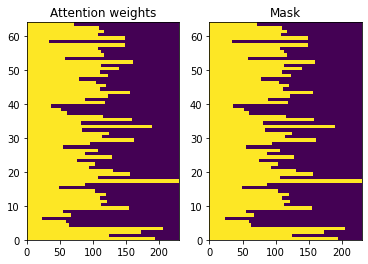

In [166]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

## Decoder

In [170]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units, GRU=True):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                    units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        if not GRU:
            self.rnn = (tf.keras.layers \
                        .SimpleRNN(units,
                        # Return the sequence and state
                        return_sequences=True,
                        return_state=True,
                        recurrent_initializer='glorot_uniform'))
        else:
            self.rnn = (tf.keras.layers \
                        .GRU(units,
                        # Return the sequence and state
                        return_sequences=True,
                        return_state=True,
                        recurrent_initializer='glorot_uniform'))

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

    def call(self,
            context, x,
            state=None,
            return_state=False):  
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch t')
        shape_checker(context, 'batch s units')

        # 1. Lookup the embeddings
        x = self.embedding(x)
        shape_checker(x, 'batch t units')

        # 2. Process the target sequence.
        x, state = self.rnn(x, initial_state=state)
        shape_checker(x, 'batch t units')

        # 3. Use the RNN output as the query for the attention over the context.
        x = self.attention(x, context)
        self.last_attention_weights = self.attention.last_attention_weights
        shape_checker(x, 'batch t units')
        shape_checker(self.last_attention_weights, 'batch t s')

        # Step 4. Generate logit predictions for the next token.
        logits = self.output_layer(x)
        shape_checker(logits, 'batch t target_vocab_size')

        if return_state:
            return logits, state
        else:
            return logits

decoder = Decoder(tit_text_processor, UNITS, GRU=True)
logits = decoder(ex_context, ex_tar_in)

decoder = Decoder(tit_text_processor, UNITS, GRU=False)
logits = decoder(ex_context, ex_tar_in)

In [171]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [172]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [173]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [174]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'interpreter jose erin donghui misu melnicka extension agenda-driven lookup michel',
       b'english-manipuri mishra type ipn hyponymy ets torsten eliminating eiichiro explanation',
       b'levy third-order felice cepstral question-answer maite coarse-to-fine articles sampo historical'],
      dtype=object)

## Summarisation Model (_Translator_)

In [175]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor,
               GRU=True):
    super().__init__()
    # Build the encoder and decoder
    # GRU False will result in SimpleRNN instead of GRU
    self.encoder = Encoder(context_text_processor, units, GRU=GRU)
    self.decoder = Decoder(target_text_processor, units, GRU=GRU)

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [178]:
UNITS = 256
model = Translator(UNITS, abs_text_processor, tit_text_processor, GRU=True)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 230)
Target tokens, shape: (batch, t) (64, 20)
logits, shape: (batch, t, target_vocabulary_size) (64, 20, 10479)


## Training

In [150]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

### GRU

In [184]:
UNITS = 256
modelGRU = Translator(UNITS, abs_text_processor, tit_text_processor, GRU=True)

logits = modelGRU((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 230)
Target tokens, shape: (batch, t) (64, 20)
logits, shape: (batch, t, target_vocabulary_size) (64, 20, 10479)


In [185]:
modelGRU.compile(
    loss=masked_loss,
    optimizer='Adam',
    metrics=[masked_accuracy])

In [186]:
with tf.device('/device:GPU:0'):
    historyGRU = modelGRU.fit(train_ds,
                            epochs=30,
                            validation_data=val_ds,
                            callbacks=tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                patience=3))

Epoch 1/30
136/136 [==============================] - 21s 98ms/step - loss: 6.6543 - masked_accuracy: 0.1305 - val_loss: 5.9750 - val_masked_accuracy: 0.1810
Epoch 2/30
136/136 [==============================] - 11s 80ms/step - loss: 5.3966 - masked_accuracy: 0.2119 - val_loss: 5.5962 - val_masked_accuracy: 0.2249
Epoch 3/30
136/136 [==============================] - 10s 73ms/step - loss: 4.6421 - masked_accuracy: 0.2669 - val_loss: 5.5946 - val_masked_accuracy: 0.2387
Epoch 4/30
136/136 [==============================] - 10s 72ms/step - loss: 4.0081 - masked_accuracy: 0.3250 - val_loss: 5.6889 - val_masked_accuracy: 0.2398
Epoch 5/30
136/136 [==============================] - 10s 72ms/step - loss: 3.4408 - masked_accuracy: 0.3804 - val_loss: 5.8606 - val_masked_accuracy: 0.2448
Epoch 6/30
136/136 [==============================] - 10s 70ms/step - loss: 2.9454 - masked_accuracy: 0.4396 - val_loss: 6.0886 - val_masked_accuracy: 0.2382


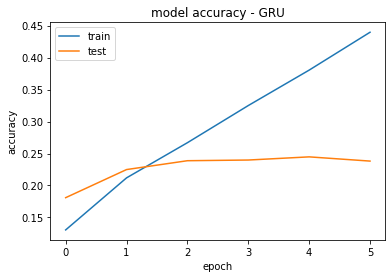

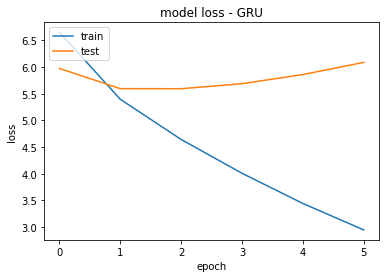

In [187]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(historyGRU.history['masked_accuracy'])
plt.plot(historyGRU.history['val_masked_accuracy'])
plt.title('model accuracy - GRU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyGRU.history['loss'])
plt.plot(historyGRU.history['val_loss'])
plt.title('model loss - GRU')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [188]:
modelGRU.summary()

Model: "translator_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_11 (Encoder)        multiple                  7403520   
                                                                 
 decoder_13 (Decoder)        multiple                  6034159   
                                                                 
Total params: 13,437,679
Trainable params: 13,437,679
Non-trainable params: 0
_________________________________________________________________


### SimpleRNN

In [189]:
UNITS = 256
modelRNN = Translator(UNITS, abs_text_processor, tit_text_processor, GRU=False)

logits = modelRNN((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 230)
Target tokens, shape: (batch, t) (64, 20)
logits, shape: (batch, t, target_vocabulary_size) (64, 20, 10479)


In [190]:
modelRNN.compile(
    loss=masked_loss,
    optimizer='Adam',
    metrics=[masked_accuracy])

In [191]:
with tf.device('/device:GPU:0'):
    historyRNN = modelRNN.fit(train_ds,
                            epochs=30,
                            validation_data=val_ds,
                            callbacks=tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                patience=3))

Epoch 1/30
136/136 [==============================] - 63s 446ms/step - loss: 6.8039 - masked_accuracy: 0.1172 - val_loss: 6.3806 - val_masked_accuracy: 0.1447
Epoch 2/30
136/136 [==============================] - 56s 412ms/step - loss: 5.8379 - masked_accuracy: 0.1632 - val_loss: 6.0191 - val_masked_accuracy: 0.1865
Epoch 3/30
136/136 [==============================] - 59s 434ms/step - loss: 5.2718 - masked_accuracy: 0.2064 - val_loss: 5.8721 - val_masked_accuracy: 0.2041
Epoch 4/30
136/136 [==============================] - 57s 420ms/step - loss: 4.6796 - masked_accuracy: 0.2492 - val_loss: 5.8611 - val_masked_accuracy: 0.2209
Epoch 5/30
136/136 [==============================] - 59s 435ms/step - loss: 4.0644 - masked_accuracy: 0.3090 - val_loss: 5.9902 - val_masked_accuracy: 0.2179
Epoch 6/30
136/136 [==============================] - 56s 409ms/step - loss: 3.5000 - masked_accuracy: 0.3869 - val_loss: 6.1308 - val_masked_accuracy: 0.2076
Epoch 7/30
136/136 [==========================

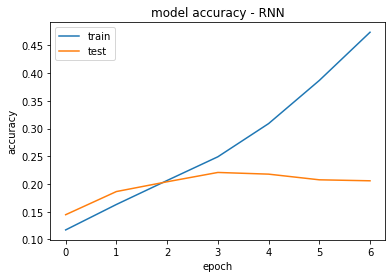

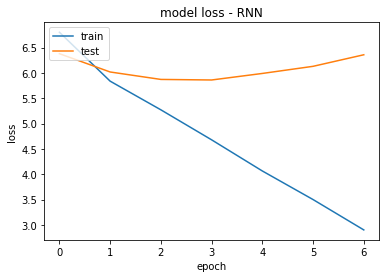

In [192]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(historyRNN.history['masked_accuracy'])
plt.plot(historyRNN.history['val_masked_accuracy'])
plt.title('model accuracy - RNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyRNN.history['loss'])
plt.plot(historyRNN.history['val_loss'])
plt.title('model loss - RNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [193]:
modelRNN.summary()

Model: "translator_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_12 (Encoder)        multiple                  7140096   
                                                                 
 decoder_14 (Decoder)        multiple                  5770735   
                                                                 
Total params: 12,910,831
Trainable params: 12,910,831
Non-trainable params: 0
_________________________________________________________________
